In [69]:
import pandas as pd
df = pd.read_csv("train.csv")

df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [70]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [71]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [72]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

In [73]:
df["Age"] = df["Age"].fillna(df["Age"].mean())

In [74]:
df["Embarked"] = df["Embarked"].map({"S" : 0,"C" :1 ,"Q": 2})

In [75]:
dfd = df.drop(columns=["Cabin","Name","Ticket","Fare","Embarked"])

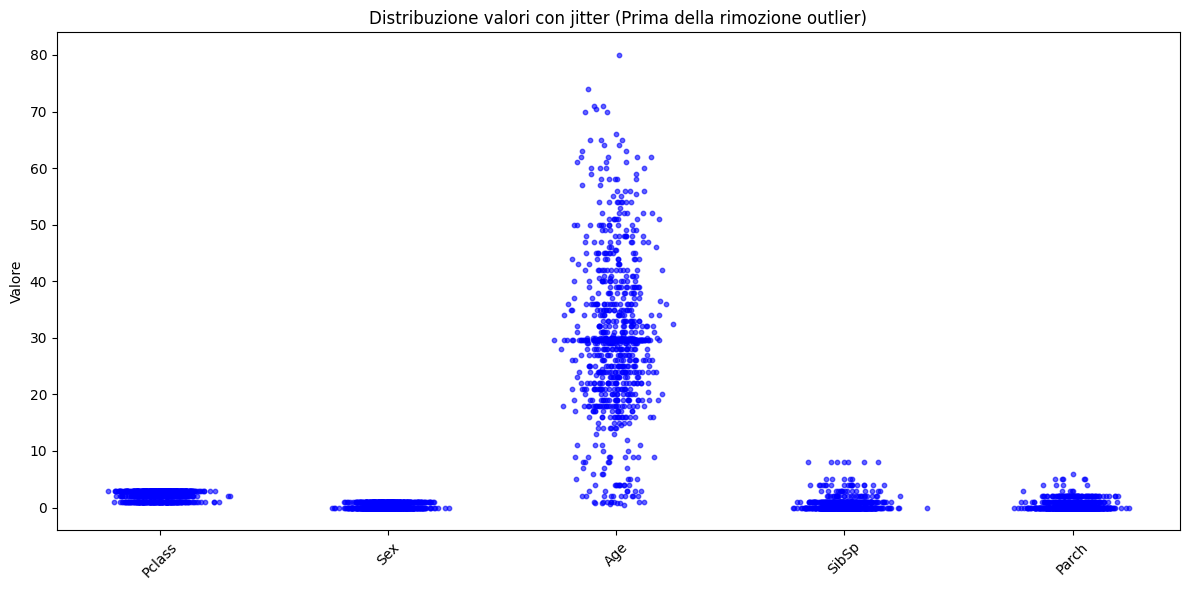

In [76]:
import matplotlib.pyplot as plt
import numpy as np


numeric_cols = dfd.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop(["Survived"])
numeric_cols = [col for col in numeric_cols if col != "PassengerId"]

plt.figure(figsize=(12, 6))

for i, col in enumerate(numeric_cols):
    data = dfd[col].dropna()  
    if len(data) == 0:
        continue
    
    # Jitter sull'asse x
    x = np.random.normal(i, 0.08, size=len(data))
    plt.scatter(x, data.values, alpha=0.6, s=10, color='blue')

plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.title("Distribuzione valori con jitter (Prima della rimozione outlier)")
plt.ylabel("Valore")
plt.tight_layout()
plt.show()


In [77]:
dfd.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
dtype: int64

In [78]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    dfd[col] = np.where(dfd[col].between(lower, upper), dfd[col], np.nan)

In [79]:
from sklearn.model_selection import train_test_split


X = dfd[numeric_cols].copy()
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [80]:
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

X = dfd[numeric_cols].copy()          
y = df['Survived']                     

X = X.fillna(X.median())


In [81]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_jobs': -1,
        'random_state': 42,
    }

    model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return scores.mean()


study = optuna.create_study(direction='maximize', study_name="XGBoost_Titanic")
study.optimize(objective, n_trials=50, show_progress_bar=True)


print("\n--- Risultati Ottimizzazione ---")
print(f"Miglior Trial (Tentativo #{study.best_trial.number})")
print(f"Accuratezza Migliore (CV): {study.best_value:.4f}")
print("Migliori Iperparametri:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)
final_acc = final_model.score(X_test, y_test)
print(f"\nAccuratezza Finale sul Test Set: {final_acc:.4f}")


[I 2025-12-05 12:45:15,865] A new study created in memory with name: XGBoost_Titanic
Best trial: 0. Best value: 0.796405:   2%|▏         | 1/50 [00:00<00:30,  1.60it/s]

[I 2025-12-05 12:45:16,490] Trial 0 finished with value: 0.796405003447257 and parameters: {'n_estimators': 182, 'learning_rate': 0.048321333349001454, 'max_depth': 4, 'subsample': 0.9488025415972291, 'colsample_bytree': 0.562189821847598, 'reg_alpha': 9.04047472864955, 'reg_lambda': 0.005501849688455462}. Best is trial 0 with value: 0.796405003447257.


Best trial: 0. Best value: 0.796405:   4%|▍         | 2/50 [00:06<02:54,  3.64s/it]

[I 2025-12-05 12:45:22,245] Trial 1 finished with value: 0.7907022554909878 and parameters: {'n_estimators': 982, 'learning_rate': 0.0015772885795000394, 'max_depth': 6, 'subsample': 0.7782006421959855, 'colsample_bytree': 0.5207609787503572, 'reg_alpha': 0.05442606897246612, 'reg_lambda': 0.006362457295896072}. Best is trial 0 with value: 0.796405003447257.


Best trial: 2. Best value: 0.797715:   6%|▌         | 3/50 [00:10<02:58,  3.81s/it]

[I 2025-12-05 12:45:26,251] Trial 2 finished with value: 0.7977149610952428 and parameters: {'n_estimators': 653, 'learning_rate': 0.0016015829766395599, 'max_depth': 5, 'subsample': 0.8656656719388538, 'colsample_bytree': 0.7923393509866024, 'reg_alpha': 1.952066985066894e-08, 'reg_lambda': 3.40347552547323e-08}. Best is trial 2 with value: 0.7977149610952428.


Best trial: 2. Best value: 0.797715:   8%|▊         | 4/50 [00:15<03:27,  4.51s/it]

[I 2025-12-05 12:45:31,836] Trial 3 finished with value: 0.7795626908302964 and parameters: {'n_estimators': 930, 'learning_rate': 0.09686400457842614, 'max_depth': 5, 'subsample': 0.7133608158854934, 'colsample_bytree': 0.7702361942442664, 'reg_alpha': 3.670204706909792e-07, 'reg_lambda': 1.626803923849252e-08}. Best is trial 2 with value: 0.7977149610952428.


Best trial: 2. Best value: 0.797715:  10%|█         | 5/50 [00:21<03:32,  4.73s/it]

[I 2025-12-05 12:45:36,954] Trial 4 finished with value: 0.7808529498670344 and parameters: {'n_estimators': 572, 'learning_rate': 0.002077736583156458, 'max_depth': 13, 'subsample': 0.895888139230626, 'colsample_bytree': 0.5555030382187727, 'reg_alpha': 1.832579719783188e-08, 'reg_lambda': 8.178231125102887e-07}. Best is trial 2 with value: 0.7977149610952428.


Best trial: 5. Best value: 0.810421:  12%|█▏        | 6/50 [00:23<02:56,  4.02s/it]

[I 2025-12-05 12:45:39,594] Trial 5 finished with value: 0.810420565350143 and parameters: {'n_estimators': 485, 'learning_rate': 0.005762008514380567, 'max_depth': 5, 'subsample': 0.5327663310166229, 'colsample_bytree': 0.7721146367518464, 'reg_alpha': 1.7951826310393268, 'reg_lambda': 0.008295138689159477}. Best is trial 5 with value: 0.810420565350143.


Best trial: 6. Best value: 0.813218:  14%|█▍        | 7/50 [00:25<02:23,  3.33s/it]

[I 2025-12-05 12:45:41,517] Trial 6 finished with value: 0.8132177681473456 and parameters: {'n_estimators': 351, 'learning_rate': 0.06998594377230001, 'max_depth': 10, 'subsample': 0.7095466109252417, 'colsample_bytree': 0.8168095836906817, 'reg_alpha': 2.846686034493139, 'reg_lambda': 0.2766045952999064}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  16%|█▌        | 8/50 [00:34<03:35,  5.14s/it]

[I 2025-12-05 12:45:50,518] Trial 7 finished with value: 0.8089924160346694 and parameters: {'n_estimators': 937, 'learning_rate': 0.007200798928268629, 'max_depth': 14, 'subsample': 0.5083211125840652, 'colsample_bytree': 0.7952454949467576, 'reg_alpha': 1.4329570212117328e-05, 'reg_lambda': 0.00012576589458995245}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  18%|█▊        | 9/50 [00:43<04:21,  6.37s/it]

[I 2025-12-05 12:45:59,585] Trial 8 finished with value: 0.8117797695262483 and parameters: {'n_estimators': 857, 'learning_rate': 0.0035070605917316275, 'max_depth': 15, 'subsample': 0.699682198824533, 'colsample_bytree': 0.7759478383949758, 'reg_alpha': 1.6143161990510017e-06, 'reg_lambda': 0.13109542600712798}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  20%|██        | 10/50 [00:49<04:05,  6.13s/it]

[I 2025-12-05 12:46:05,173] Trial 9 finished with value: 0.7850684526740864 and parameters: {'n_estimators': 869, 'learning_rate': 0.001316071336161152, 'max_depth': 7, 'subsample': 0.7557049740018904, 'colsample_bytree': 0.5319953240101776, 'reg_alpha': 0.00991555248214384, 'reg_lambda': 5.687017826640315e-08}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  22%|██▏       | 11/50 [00:50<03:00,  4.63s/it]

[I 2025-12-05 12:46:06,425] Trial 10 finished with value: 0.7879542992219049 and parameters: {'n_estimators': 138, 'learning_rate': 0.29997859225145385, 'max_depth': 10, 'subsample': 0.6228908486585132, 'colsample_bytree': 0.9599349416507066, 'reg_alpha': 0.001043288819177448, 'reg_lambda': 2.0951173380382313}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  24%|██▍       | 12/50 [00:53<02:35,  4.10s/it]

[I 2025-12-05 12:46:09,289] Trial 11 finished with value: 0.8117797695262483 and parameters: {'n_estimators': 343, 'learning_rate': 0.025131280429854876, 'max_depth': 11, 'subsample': 0.6443104136396913, 'colsample_bytree': 0.8869684410472535, 'reg_alpha': 4.381455995002151e-05, 'reg_lambda': 8.1589530145802}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  26%|██▌       | 13/50 [01:00<03:07,  5.06s/it]

[I 2025-12-05 12:46:16,559] Trial 12 finished with value: 0.8047769132276175 and parameters: {'n_estimators': 733, 'learning_rate': 0.009463076081268314, 'max_depth': 15, 'subsample': 0.6703073503175785, 'colsample_bytree': 0.6632862191666321, 'reg_alpha': 1.9944701526477577e-06, 'reg_lambda': 0.2921464575526114}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  28%|██▊       | 14/50 [01:04<02:44,  4.56s/it]

[I 2025-12-05 12:46:19,981] Trial 13 finished with value: 0.7879641485275288 and parameters: {'n_estimators': 383, 'learning_rate': 0.09282436139301817, 'max_depth': 12, 'subsample': 0.8148147694685086, 'colsample_bytree': 0.6666985843582117, 'reg_alpha': 0.13079856770204132, 'reg_lambda': 0.1344448750822362}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  30%|███       | 15/50 [01:06<02:20,  4.01s/it]

[I 2025-12-05 12:46:22,723] Trial 14 finished with value: 0.7949571555205358 and parameters: {'n_estimators': 300, 'learning_rate': 0.025713804908811155, 'max_depth': 8, 'subsample': 0.5860191440114918, 'colsample_bytree': 0.8700864538775945, 'reg_alpha': 0.0007401367039192087, 'reg_lambda': 0.0002140471072864117}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  32%|███▏      | 16/50 [01:13<02:44,  4.85s/it]

[I 2025-12-05 12:46:29,509] Trial 15 finished with value: 0.8103910174332709 and parameters: {'n_estimators': 771, 'learning_rate': 0.0038916952049453824, 'max_depth': 9, 'subsample': 0.7008716388492401, 'colsample_bytree': 0.6582065077848398, 'reg_alpha': 5.283405658860174e-07, 'reg_lambda': 0.13710363081769278}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  34%|███▍      | 17/50 [01:18<02:40,  4.85s/it]

[I 2025-12-05 12:46:34,362] Trial 16 finished with value: 0.7823303457106274 and parameters: {'n_estimators': 515, 'learning_rate': 0.25215847322231866, 'max_depth': 15, 'subsample': 0.8013890293913758, 'colsample_bytree': 0.8676976066776412, 'reg_alpha': 3.217802043603885e-05, 'reg_lambda': 8.136210376779245e-06}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  36%|███▌      | 18/50 [01:21<02:13,  4.17s/it]

[I 2025-12-05 12:46:36,953] Trial 17 finished with value: 0.8075642667191965 and parameters: {'n_estimators': 257, 'learning_rate': 0.014055157036895466, 'max_depth': 12, 'subsample': 0.9977819857457838, 'colsample_bytree': 0.7159063755030795, 'reg_alpha': 0.005333631991913449, 'reg_lambda': 0.9654371801231674}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  38%|███▊      | 19/50 [01:22<01:46,  3.43s/it]

[I 2025-12-05 12:46:38,659] Trial 18 finished with value: 0.8048064611444893 and parameters: {'n_estimators': 420, 'learning_rate': 0.05741660435668398, 'max_depth': 3, 'subsample': 0.5856013278025392, 'colsample_bytree': 0.9820069306132839, 'reg_alpha': 0.17364018811734658, 'reg_lambda': 0.02231096032297233}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  40%|████      | 20/50 [01:30<02:17,  4.59s/it]

[I 2025-12-05 12:46:45,957] Trial 19 finished with value: 0.8047670639219934 and parameters: {'n_estimators': 655, 'learning_rate': 0.003129985290840729, 'max_depth': 10, 'subsample': 0.7081650277534399, 'colsample_bytree': 0.9220976785949019, 'reg_alpha': 0.00015087558692600912, 'reg_lambda': 0.0006007064289303445}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 6. Best value: 0.813218:  42%|████▏     | 21/50 [01:36<02:30,  5.20s/it]

[I 2025-12-05 12:46:52,589] Trial 20 finished with value: 0.7879739978331527 and parameters: {'n_estimators': 831, 'learning_rate': 0.1551193361271223, 'max_depth': 13, 'subsample': 0.8434156477424267, 'colsample_bytree': 0.8215113630027305, 'reg_alpha': 1.6299536290100088e-07, 'reg_lambda': 8.340581745028606}. Best is trial 6 with value: 0.8132177681473456.


Best trial: 21. Best value: 0.814607:  44%|████▍     | 22/50 [01:39<02:06,  4.51s/it]

[I 2025-12-05 12:46:55,492] Trial 21 finished with value: 0.814606520240323 and parameters: {'n_estimators': 344, 'learning_rate': 0.03325288807699162, 'max_depth': 11, 'subsample': 0.6455674191924324, 'colsample_bytree': 0.8635760732512567, 'reg_alpha': 7.363062067714548e-06, 'reg_lambda': 6.286888033918631}. Best is trial 21 with value: 0.814606520240323.


Best trial: 21. Best value: 0.814607:  46%|████▌     | 23/50 [01:41<01:42,  3.80s/it]

[I 2025-12-05 12:46:57,619] Trial 22 finished with value: 0.8076036639416921 and parameters: {'n_estimators': 242, 'learning_rate': 0.03977251982732077, 'max_depth': 9, 'subsample': 0.7444384907245918, 'colsample_bytree': 0.7231142498064359, 'reg_alpha': 1.0746725261298992e-05, 'reg_lambda': 0.8782333593951692}. Best is trial 21 with value: 0.814606520240323.


Best trial: 21. Best value: 0.814607:  48%|████▊     | 24/50 [01:46<01:43,  3.99s/it]

[I 2025-12-05 12:47:02,046] Trial 23 finished with value: 0.7949571555205359 and parameters: {'n_estimators': 411, 'learning_rate': 0.017216708684662383, 'max_depth': 11, 'subsample': 0.6155650329413977, 'colsample_bytree': 0.8470470874090212, 'reg_alpha': 3.2070253549136875e-06, 'reg_lambda': 0.029070991265437333}. Best is trial 21 with value: 0.814606520240323.


Best trial: 21. Best value: 0.814607:  50%|█████     | 25/50 [01:47<01:17,  3.09s/it]

[I 2025-12-05 12:47:03,048] Trial 24 finished with value: 0.796375455530385 and parameters: {'n_estimators': 104, 'learning_rate': 0.07815118810974857, 'max_depth': 8, 'subsample': 0.6667298701929956, 'colsample_bytree': 0.9177556018689126, 'reg_alpha': 0.00016132651616953172, 'reg_lambda': 0.00119189508052996}. Best is trial 21 with value: 0.814606520240323.


Best trial: 21. Best value: 0.814607:  52%|█████▏    | 26/50 [01:53<01:36,  4.04s/it]

[I 2025-12-05 12:47:09,287] Trial 25 finished with value: 0.7865458485176795 and parameters: {'n_estimators': 568, 'learning_rate': 0.03107168263918865, 'max_depth': 13, 'subsample': 0.7430744308530133, 'colsample_bytree': 0.8245867426873068, 'reg_alpha': 9.317568581502592e-08, 'reg_lambda': 0.15462004191191847}. Best is trial 21 with value: 0.814606520240323.


Best trial: 21. Best value: 0.814607:  54%|█████▍    | 27/50 [01:55<01:17,  3.36s/it]

[I 2025-12-05 12:47:11,058] Trial 26 finished with value: 0.8061656653205949 and parameters: {'n_estimators': 218, 'learning_rate': 0.011308060550342136, 'max_depth': 11, 'subsample': 0.5633799048297227, 'colsample_bytree': 0.7279342257376606, 'reg_alpha': 2.7173611373896084e-06, 'reg_lambda': 2.0869496151233426}. Best is trial 21 with value: 0.814606520240323.


Best trial: 21. Best value: 0.814607:  56%|█████▌    | 28/50 [01:57<01:06,  3.01s/it]

[I 2025-12-05 12:47:13,262] Trial 27 finished with value: 0.8019994090416626 and parameters: {'n_estimators': 332, 'learning_rate': 0.1810638055181576, 'max_depth': 14, 'subsample': 0.677264481666425, 'colsample_bytree': 0.6215157432011441, 'reg_alpha': 1.0585264343326506, 'reg_lambda': 3.1949859132422636e-05}. Best is trial 21 with value: 0.814606520240323.


Best trial: 21. Best value: 0.814607:  58%|█████▊    | 29/50 [02:01<01:11,  3.42s/it]

[I 2025-12-05 12:47:17,631] Trial 28 finished with value: 0.7837584950261007 and parameters: {'n_estimators': 452, 'learning_rate': 0.07057098104358021, 'max_depth': 10, 'subsample': 0.6366190984677181, 'colsample_bytree': 0.9199350885674886, 'reg_alpha': 0.0053269406768213625, 'reg_lambda': 0.043864891152971}. Best is trial 21 with value: 0.814606520240323.


Best trial: 29. Best value: 0.814616:  60%|██████    | 30/50 [02:05<01:08,  3.41s/it]

[I 2025-12-05 12:47:21,023] Trial 29 finished with value: 0.8146163695459471 and parameters: {'n_estimators': 617, 'learning_rate': 0.041619296766766116, 'max_depth': 12, 'subsample': 0.7150792239396786, 'colsample_bytree': 0.8379893627795703, 'reg_alpha': 2.8159893761618333, 'reg_lambda': 0.0024346418897450354}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  62%|██████▏   | 31/50 [02:07<00:56,  2.98s/it]

[I 2025-12-05 12:47:22,996] Trial 30 finished with value: 0.8076430611641878 and parameters: {'n_estimators': 660, 'learning_rate': 0.04618504079621003, 'max_depth': 12, 'subsample': 0.7850785878795024, 'colsample_bytree': 0.8287037928009038, 'reg_alpha': 8.13409670155886, 'reg_lambda': 0.002088010482132102}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  64%|██████▍   | 32/50 [02:09<00:50,  2.79s/it]

[I 2025-12-05 12:47:25,356] Trial 31 finished with value: 0.8062346104599627 and parameters: {'n_estimators': 604, 'learning_rate': 0.020002779468441253, 'max_depth': 14, 'subsample': 0.7219510581716925, 'colsample_bytree': 0.7502205175171536, 'reg_alpha': 6.546095779740097, 'reg_lambda': 0.39753305439668407}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  66%|██████▌   | 33/50 [02:15<01:06,  3.91s/it]

[I 2025-12-05 12:47:31,854] Trial 32 finished with value: 0.7879542992219049 and parameters: {'n_estimators': 759, 'learning_rate': 0.03694186243027898, 'max_depth': 9, 'subsample': 0.683689012365828, 'colsample_bytree': 0.8916316622440464, 'reg_alpha': 0.7044664862321544, 'reg_lambda': 0.003685918607254663}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  68%|██████▊   | 34/50 [02:17<00:51,  3.22s/it]

[I 2025-12-05 12:47:33,480] Trial 33 finished with value: 0.803398010440264 and parameters: {'n_estimators': 188, 'learning_rate': 0.14478542382670287, 'max_depth': 11, 'subsample': 0.6537957173786093, 'colsample_bytree': 0.7923972273957679, 'reg_alpha': 0.03202858551884029, 'reg_lambda': 2.646586060140198}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  70%|███████   | 35/50 [02:22<00:55,  3.67s/it]

[I 2025-12-05 12:47:38,213] Trial 34 finished with value: 0.7907613513247316 and parameters: {'n_estimators': 491, 'learning_rate': 0.04987890459216123, 'max_depth': 12, 'subsample': 0.7650463975101306, 'colsample_bytree': 0.8444895539951462, 'reg_alpha': 0.3518549617835004, 'reg_lambda': 0.03429618013834767}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  72%|███████▏  | 36/50 [02:25<00:50,  3.59s/it]

[I 2025-12-05 12:47:41,609] Trial 35 finished with value: 0.8048064611444893 and parameters: {'n_estimators': 702, 'learning_rate': 0.11390534032627782, 'max_depth': 15, 'subsample': 0.7212631095248068, 'colsample_bytree': 0.7986233547311887, 'reg_alpha': 2.3706629297218007, 'reg_lambda': 0.4196355184203527}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  74%|███████▍  | 37/50 [02:33<01:02,  4.83s/it]

[I 2025-12-05 12:47:49,318] Trial 36 finished with value: 0.8033586132177681 and parameters: {'n_estimators': 998, 'learning_rate': 0.002178669211428613, 'max_depth': 7, 'subsample': 0.5974494677736376, 'colsample_bytree': 0.7636665769530918, 'reg_alpha': 6.403741760996125e-07, 'reg_lambda': 0.006591184922609804}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  76%|███████▌  | 38/50 [02:41<01:09,  5.76s/it]

[I 2025-12-05 12:47:57,272] Trial 37 finished with value: 0.7781246922091993 and parameters: {'n_estimators': 818, 'learning_rate': 0.05776253549430826, 'max_depth': 13, 'subsample': 0.9245472288925564, 'colsample_bytree': 0.70225506596714, 'reg_alpha': 7.110104942894635e-08, 'reg_lambda': 0.07833897290843668}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  78%|███████▊  | 39/50 [02:51<01:18,  7.11s/it]

[I 2025-12-05 12:48:07,505] Trial 38 finished with value: 0.8005811090318133 and parameters: {'n_estimators': 929, 'learning_rate': 0.00542674294583376, 'max_depth': 10, 'subsample': 0.8405086154219432, 'colsample_bytree': 0.9513806525144439, 'reg_alpha': 0.03249762630754665, 'reg_lambda': 0.011533100460266508}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  80%|████████  | 40/50 [02:56<01:05,  6.57s/it]

[I 2025-12-05 12:48:12,836] Trial 39 finished with value: 0.8033881611346398 and parameters: {'n_estimators': 531, 'learning_rate': 0.019965819268767893, 'max_depth': 14, 'subsample': 0.6964160516479163, 'colsample_bytree': 0.7803764807444378, 'reg_alpha': 6.991627682668909e-06, 'reg_lambda': 6.615356611124816e-05}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  82%|████████▏ | 41/50 [03:00<00:49,  5.52s/it]

[I 2025-12-05 12:48:15,910] Trial 40 finished with value: 0.8132079188417215 and parameters: {'n_estimators': 366, 'learning_rate': 0.030603578108520914, 'max_depth': 8, 'subsample': 0.5405644916062755, 'colsample_bytree': 0.8080780158162639, 'reg_alpha': 3.584219732442323e-05, 'reg_lambda': 4.068087180332729}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  84%|████████▍ | 42/50 [03:02<00:35,  4.48s/it]

[I 2025-12-05 12:48:17,942] Trial 41 finished with value: 0.8075741160248203 and parameters: {'n_estimators': 288, 'learning_rate': 0.029094628471412944, 'max_depth': 6, 'subsample': 0.5286840603071257, 'colsample_bytree': 0.8094876375049282, 'reg_alpha': 5.085096095035493e-05, 'reg_lambda': 4.105915087677462}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  86%|████████▌ | 43/50 [03:05<00:28,  4.01s/it]

[I 2025-12-05 12:48:20,870] Trial 42 finished with value: 0.768216290751502 and parameters: {'n_estimators': 349, 'learning_rate': 0.0010952029405051906, 'max_depth': 8, 'subsample': 0.557532784408713, 'colsample_bytree': 0.8630644623306737, 'reg_alpha': 0.0008348641641037894, 'reg_lambda': 0.8639507685361891}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  88%|████████▊ | 44/50 [03:07<00:21,  3.65s/it]

[I 2025-12-05 12:48:23,670] Trial 43 finished with value: 0.8089825667290456 and parameters: {'n_estimators': 454, 'learning_rate': 0.013124629927182902, 'max_depth': 7, 'subsample': 0.7348871475641212, 'colsample_bytree': 0.7556399686618028, 'reg_alpha': 1.0858867960099056e-06, 'reg_lambda': 8.430798965945415}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  90%|█████████ | 45/50 [03:11<00:18,  3.61s/it]

[I 2025-12-05 12:48:27,182] Trial 44 finished with value: 0.7977839062346105 and parameters: {'n_estimators': 405, 'learning_rate': 0.03739271771695767, 'max_depth': 11, 'subsample': 0.615731451435426, 'colsample_bytree': 0.8421369480423035, 'reg_alpha': 1.0724414635571106e-08, 'reg_lambda': 1.0501872993725463}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  92%|█████████▏| 46/50 [03:15<00:15,  3.86s/it]

[I 2025-12-05 12:48:31,643] Trial 45 finished with value: 0.810371318822023 and parameters: {'n_estimators': 607, 'learning_rate': 0.008018158432867175, 'max_depth': 8, 'subsample': 0.5017611991132678, 'colsample_bytree': 0.8926582077079949, 'reg_alpha': 2.289916581379702e-05, 'reg_lambda': 3.5048196693040774}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  94%|█████████▍| 47/50 [03:18<00:10,  3.59s/it]

[I 2025-12-05 12:48:34,592] Trial 46 finished with value: 0.7963853048360091 and parameters: {'n_estimators': 363, 'learning_rate': 0.07463480916047753, 'max_depth': 9, 'subsample': 0.785988967506689, 'colsample_bytree': 0.7789646136949354, 'reg_alpha': 6.798365167053008e-06, 'reg_lambda': 0.18945785049102484}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  96%|█████████▌| 48/50 [03:20<00:05,  2.95s/it]

[I 2025-12-05 12:48:36,051] Trial 47 finished with value: 0.8104107160445189 and parameters: {'n_estimators': 308, 'learning_rate': 0.10277031146985413, 'max_depth': 10, 'subsample': 0.6488919103646523, 'colsample_bytree': 0.6920008847245053, 'reg_alpha': 3.171551972945026, 'reg_lambda': 0.06379980548562666}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616:  98%|█████████▊| 49/50 [03:26<00:03,  3.92s/it]

[I 2025-12-05 12:48:42,235] Trial 48 finished with value: 0.8047966118388654 and parameters: {'n_estimators': 948, 'learning_rate': 0.022340216007657104, 'max_depth': 6, 'subsample': 0.5486143792534892, 'colsample_bytree': 0.7398349081349873, 'reg_alpha': 0.0003582794868263027, 'reg_lambda': 8.673949842639031e-07}. Best is trial 29 with value: 0.8146163695459471.


Best trial: 29. Best value: 0.814616: 100%|██████████| 50/50 [03:28<00:00,  4.16s/it]


[I 2025-12-05 12:48:43,915] Trial 49 finished with value: 0.799162809021964 and parameters: {'n_estimators': 162, 'learning_rate': 0.03230030613187374, 'max_depth': 12, 'subsample': 0.6842940842677163, 'colsample_bytree': 0.8036210390822621, 'reg_alpha': 6.783411408497966e-05, 'reg_lambda': 0.5285179086815509}. Best is trial 29 with value: 0.8146163695459471.

--- Risultati Ottimizzazione ---
Miglior Trial (Tentativo #29)
Accuratezza Migliore (CV): 0.8146
Migliori Iperparametri:
  n_estimators: 617
  learning_rate: 0.041619296766766116
  max_depth: 12
  subsample: 0.7150792239396786
  colsample_bytree: 0.8379893627795703
  reg_alpha: 2.8159893761618333
  reg_lambda: 0.0024346418897450354

Accuratezza Finale sul Test Set: 0.8045
